# MAML with torchmeta

In [1]:
from torchmeta.datasets.helpers import miniimagenet, omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from torchmeta.modules import MetaModule, MetaSequential, MetaConv2d, MetaBatchNorm2d, MetaLinear

from learn2learn.vision.datasets import MiniImagenet as l2l_miniimgnet

import higher

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

from collections import OrderedDict

In [2]:
%config Completer.use_jedi = False

In [30]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = 'cpu'

In [3]:
data = miniimagenet("../data/", shots=5, ways=5, test_shots=15, meta_split="train", download='True')

In [4]:
# l2l_data = l2l_miniimgnet("../data/",
#                       mode='train',
#                       transform=None,
#                       target_transform=None,
#                       download=True)

In [4]:
dataloader = BatchMetaDataLoader(data, batch_size=1, num_workers=4, shuffle=False)

In [5]:
dataiter = iter(dataloader)
d = dataiter.next()
train_images, train_labels = d['train']

In [8]:
def c_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

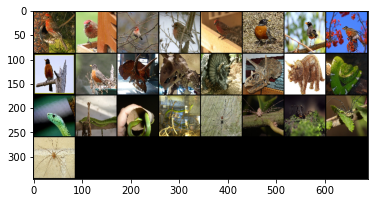

In [7]:
c_imshow(torchvision.utils.make_grid(train_images[0]))

## implement a supervised meta learner for the images

In [5]:
def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points
    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.
    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [65]:
def conv3x3(in_channels, out_channels, **kwargs):
    return MetaSequential(
        MetaConv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        MetaBatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [66]:
class CNN(MetaModule):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size
        
        self.features = MetaSequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )
        self.classifier = MetaLinear(hidden_size, out_features)
        
    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits

In [12]:
dataset = omniglot('../data/',
                       shots=5,
                       ways=5,
                       shuffle=True,
                       test_shots=15,
                       meta_train=True,
                       download=True)

In [13]:
dataloader = BatchMetaDataLoader(dataset, batch_size=16, num_workers=4, shuffle=False)

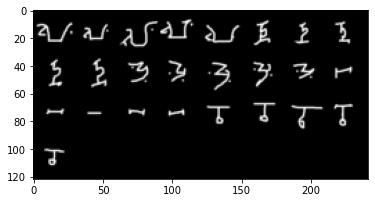

In [14]:
dataiter = iter(dataloader)
d = dataiter.next()
train_images, train_labels = d['train']
c_imshow(torchvision.utils.make_grid(train_images[0]))

In [35]:
tex, tey = d['test']

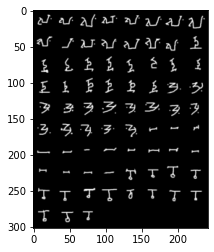

In [39]:
c_imshow(torchvision.utils.make_grid(tex[0]))

In [41]:
task_num, setsz, c_, h, w = train_images.size()
task_num, setsz, c_, h, w 

(16, 25, 1, 28, 28)

In [67]:
model = CNN(1, 5, hidden_size=64)
model.to(device='cuda')
model.train()
meta_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
with tqdm.notebook.tqdm(dataloader, total=100) as pbar:
        for batch_idx, batch in enumerate(pbar):
            model.zero_grad()

            train_inputs, train_targets = batch['train']
            train_inputs = train_inputs.to(device='cuda')
            train_targets = train_targets.to(device='cuda')

            test_inputs, test_targets = batch['test']
            test_inputs = test_inputs.to(device='cuda')
            test_targets = test_targets.to(device='cuda')
            
#             print(test_inputs.size(1))
#             print(len(test_inputs))
#             break

            outer_loss = torch.tensor(0., device='cuda')
            accuracy = torch.tensor(0., device='cuda')
            for task_idx, (train_input, train_target, test_input,
                    test_target) in enumerate(zip(train_inputs, train_targets,
                    test_inputs, test_targets)):
                train_logit = model(train_input)
                inner_loss = F.cross_entropy(train_logit, train_target)

                model.zero_grad()
                params = gradient_update_parameters(model,
                                                    inner_loss,
                                                    step_size=.4,
                                                    first_order=False)

                test_logit = model(test_input, params=params)
                outer_loss += F.cross_entropy(test_logit, test_target)

                with torch.no_grad():
                    accuracy += get_accuracy(test_logit, test_target)

            outer_loss.div_(16)
            accuracy.div_(16)

            outer_loss.backward()
            meta_optimizer.step()

            pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
            if batch_idx >= 100:
                break

## MAML using higher

## creating a new normal pytorch network

In [26]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [77]:
net = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.BatchNorm2d(64, momentum=1, affine=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64, momentum=1, affine=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64, momentum=1, affine=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    
    Flatten(),
    nn.Linear(64, 5)).to(device)

In [52]:
def train(dataloader, net, device, meta_opt):
    net.train()
    with tqdm.notebook.tqdm(dataloader, total=100) as pbar:
        for b_idx, b in enumerate(pbar):
            train_inputs, train_targets = b['train']
            train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
            
            test_inputs, test_targets = batch['test']
            test_inputs = test_inputs.to(device='cuda')
            test_targets = test_targets.to(device='cuda')
            
            querysz = test_inputs.size(1)
            
            n_inner_iter = 5
            inner_opt = torch.optim.SGD(net.parameters(), lr=1e-1)
            qry_losses = []
            qry_accs = []
            meta_opt.zero_grad()
            
            for task_idx, (train_input, train_target, test_input,
                        test_target) in enumerate(zip(train_inputs, train_targets,
                        test_inputs, test_targets)):
                task_num, setsz, c_, h, w = train_images.size()
                with higher.innerloop_ctx(net, inner_opt, copy_initial_weights=False) as (fnet, diffopt):
                    
                    spt_logits = fnet(train_input)
                    spt_loss = F.cross_entropy(spt_logits, train_target)
                    diffopt.step(spt_loss)
                    
                    qry_logits = fnet(test_input)
                    
                    #### also the outer loss ####
                    qry_loss = F.cross_entropy(qry_logits, test_target)
                    qry_losses.append(qry_loss.detach())
                    qry_acc = (qry_logits.argmax(dim=1) == test_target).sum().item() / querysz
                    
                    qry_accs.append(qry_acc)
                    
                    # Update the model's meta-parameters to optimize the query
                    # losses across all of the tasks sampled in this batch.
                    # This unrolls through the gradient steps.
                    qry_loss.backward()
            
            meta_opt.step()
            qry_losses = sum(qry_losses) / task_num
            qry_accs = 100. * sum(qry_accs) / task_num
            pbar.set_postfix(accuracy='{0:.4f}'.format(qry_accs))
            
            if b_idx >= 100:
                break            
                    

In [80]:
meta_opt = torch.optim.Adam(net.parameters(), lr=1e-2)

In [82]:
train(dataloader, net, device, meta_opt)

In [50]:
tex.shape, tey.shape

(torch.Size([16, 75, 1, 28, 28]), torch.Size([16, 75]))